In [1]:
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"  # 경로만 맞추면 됩니다.

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]

print("✅ Restored all *_clean DataFrames")

✅ Restored all *_clean DataFrames


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

=== 세그먼트 매출 요약 & 전체 매출 비중 ===


,segment,sales,orders,customers,sales_share_total
0,VVIP,4563833.44,20018,20018,0.338207
1,VIP,2552221.83,19587,19587,0.189135
2,고액고객,2720813.32,19145,19145,0.201628
3,예비VIP,2681776.25,19306,19306,0.198736
4,유망,975546.30,20141,20141,0.072294


✅ 상위 세그먼트(VVIP, VIP, 고액고객) 합산 매출 비중: 72.9%


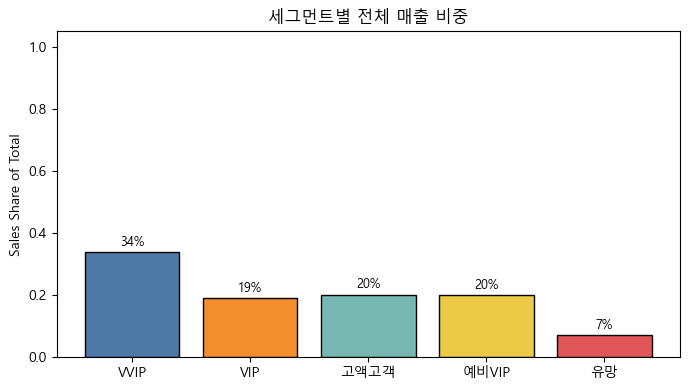

=== 세그먼트별 카테고리 Top3 (매출 기준) ===


,segment,rank_in_seg,category_en,sales,sales_share,orders,customers
0,VVIP,1.0,watches_gifts,513376.67,0.112488,2040,2040
1,VVIP,2.0,health_beauty,507586.64,0.111219,2190,2190
2,VVIP,3.0,bed_bath_table,297558.83,0.065199,1783,1783
3,VIP,1.0,watches_gifts,234860.11,0.092022,1271,1271
4,VIP,2.0,health_beauty,229691.37,0.089997,1852,1852
5,VIP,3.0,sports_leisure,225500.49,0.088355,1626,1626
6,고액고객,1.0,watches_gifts,230987.53,0.084897,967,967
7,고액고객,2.0,bed_bath_table,221595.73,0.081445,1931,1931
8,고액고객,3.0,health_beauty,218049.64,0.080141,1627,1627
9,예비VIP,1.0,health_beauty,225016.03,0.083906,1566,1566


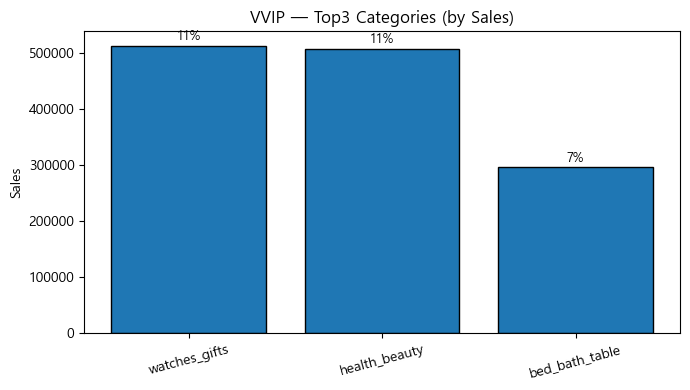

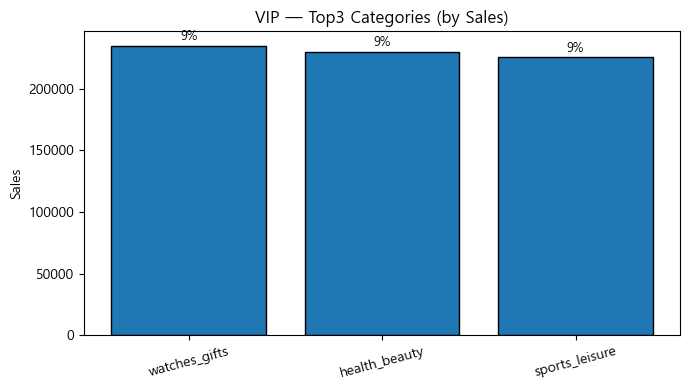

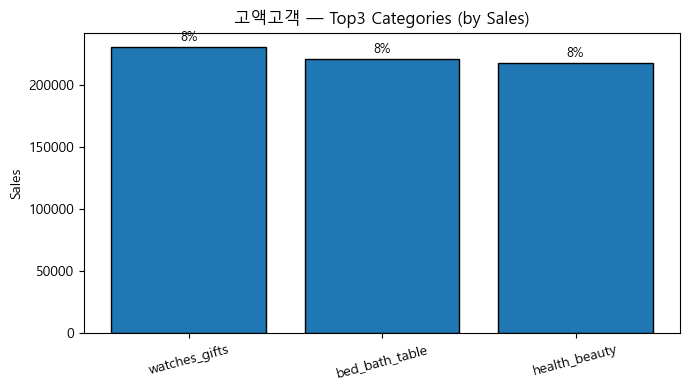

✅ 완료: rfm_customers, seg_sales_summary, seg_cat_top3, seg_cat_detail 생성


In [3]:
# =========================================================
# 상위 세그먼트 매출 비중 + 세그먼트별 카테고리 Top3 (프로모션 타깃팅용)
# 전제: *_clean DF 로드/기본 import 완료
# 산출물:
#   - rfm_customers: 고객별 R/F/M, 점수, 세그먼트
#   - seg_sales_summary: 세그먼트 매출/주문/고객/전체 매출 비중
#   - seg_cat_top3: 세그먼트별 카테고리 Top3(매출 기준)
#   - seg_cat_detail: 세그먼트×카테고리 상세
#   - (옵션) 세그먼트 매출비중 바차트, Top3 바차트
# =========================================================

# -------- 0) 준비: category_en 보장 & 트랜잭션 베이스 --------
def _ensure_category_en(products_df, cat_tr_df=None):
    if "category_en" in products_df.columns:
        return products_df
    prod = products_df.copy()
    if cat_tr_df is not None and "product_category_name" in prod.columns:
        m = cat_tr_df.set_index("product_category_name")["product_category_name_english"].to_dict()
        prod["category_en"] = prod["product_category_name"].map(m).fillna("unknown")
    else:
        prod["category_en"] = prod.get("product_category_name", "unknown")
    return prod

products_clean = _ensure_category_en(
    products_clean,
    category_tr_clean if "category_tr_clean" in globals() else None
)

valid_status = ["delivered","invoiced","shipped","processing","created"]
tx = (orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]]
      .merge(order_items_clean[["order_id","product_id","price"]], on="order_id", how="inner")
      .merge(products_clean[["product_id","category_en"]], on="product_id", how="left"))
tx = tx[tx["order_status"].isin(valid_status)].copy()

tx["order_date"]  = pd.to_datetime(tx["order_purchase_timestamp"], errors="coerce").dt.normalize()
tx["order_month"] = tx["order_date"].dt.to_period("M").dt.to_timestamp()
tx["category_en"] = tx["category_en"].fillna("unknown")
tx["price"] = pd.to_numeric(tx["price"], errors="coerce").fillna(0.0)

# -------- 1) RFM (ref=데이터 내 마지막 주문일, 같은 날=1일) --------
cust_ord = (tx.groupby(["customer_id","order_id","order_date"])["price"]
              .sum().reset_index())

ref_date = cust_ord["order_date"].max()
rfm = (cust_ord.groupby("customer_id")
       .agg(last_purchase=("order_date","max"),
            frequency=("order_id","nunique"),
            monetary=("price","sum"))
       .reset_index())
rfm["recency_days"] = (ref_date - rfm["last_purchase"]).dt.days + 1

# -------- 2) 점수화(분위 기반) --------
def quantile_score(series, n=5, higher_is_better=True):
    s = series.fillna(series.median())
    pct = s.rank(pct=True, method="average")  # 0~1
    score = np.ceil((pct if higher_is_better else (1-pct)) * n)
    return score.astype(int).clip(1, n)

rfm["r_score"] = quantile_score(rfm["recency_days"], n=5, higher_is_better=False)  # 최근일수록 높게
rfm["f_score"] = quantile_score(rfm["frequency"],   n=5, higher_is_better=True)
rfm["m_score"] = quantile_score(rfm["monetary"],    n=5, higher_is_better=True)

# -------- 3) 가중 점수 & 티어/세그먼트 --------
W_R, W_F, W_M = 0.40, 0.35, 0.25
rfm["weighted_score"] = (rfm["r_score"]*W_R + rfm["f_score"]*W_F + rfm["m_score"]*W_M)

pct_rank = rfm["weighted_score"].rank(pct=True, ascending=False)
rfm["tier"] = np.ceil(pct_rank * 5).astype(int).clip(1,5)

tier_to_seg = {1:"VVIP", 2:"VIP", 3:"고액고객", 4:"예비VIP", 5:"유망"}
rfm["segment"] = rfm["tier"].map(tier_to_seg)

rfm_customers = rfm.copy()  # 산출물 1

# -------- 4) (신규) 세그먼트 매출 비중 --------
tx_seg = tx.merge(rfm_customers[["customer_id","segment","tier","weighted_score"]],
                  on="customer_id", how="left")

seg_sales_summary = (tx_seg.groupby("segment")
                     .agg(sales=("price","sum"),
                          orders=("order_id","nunique"),
                          customers=("customer_id","nunique"))
                     .reset_index())

total_sales = seg_sales_summary["sales"].sum()
seg_sales_summary["sales_share_total"] = (seg_sales_summary["sales"] / total_sales).fillna(0.0)

# 보여줄 순서(가독성): VVIP→VIP→고액고객→예비VIP→유망
seg_order = ["VVIP","VIP","고액고객","예비VIP","유망"]
seg_sales_summary["segment"] = pd.Categorical(seg_sales_summary["segment"], categories=seg_order, ordered=True)
seg_sales_summary = seg_sales_summary.sort_values("segment").reset_index(drop=True)

# 상위 세그먼트 묶음(프로모션 당위성): VVIP+VIP+고액고객
TOP_SEGMENTS = ["VVIP","VIP","고액고객"]
top_seg_share = seg_sales_summary.loc[seg_sales_summary["segment"].isin(TOP_SEGMENTS), "sales"].sum() / max(total_sales, 1.0)

print("=== 세그먼트 매출 요약 & 전체 매출 비중 ===")
display(seg_sales_summary)

print(f"✅ 상위 세그먼트({', '.join(TOP_SEGMENTS)}) 합산 매출 비중: {top_seg_share*100:.1f}%")

# (옵션) 세그먼트 매출 비중 바차트
try:
    _plt_df = seg_sales_summary.copy()
    plt.figure(figsize=(7,4))
    bars = plt.bar(_plt_df["segment"].astype(str), _plt_df["sales_share_total"], color=["#4E79A7","#F28E2B","#76B7B2","#EDC948","#E15759"], edgecolor="black")
    for rect, v in zip(bars, _plt_df["sales_share_total"]):
        plt.text(rect.get_x()+rect.get_width()/2, rect.get_height()+0.01, f"{v*100:.0f}%", ha="center", va="bottom", fontsize=9)
    plt.ylim(0, 1.05); plt.ylabel("Sales Share of Total"); plt.title("세그먼트별 전체 매출 비중")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[seg share plot skipped]", e)

# -------- 5) 세그먼트×카테고리 집계 & Top3 --------
seg_cat = (tx_seg.groupby(["segment","category_en"])
           .agg(sales=("price","sum"),
                orders=("order_id","nunique"),
                customers=("customer_id","nunique"))
           .reset_index())

seg_total = seg_cat.groupby("segment")["sales"].sum().rename("seg_sales")
seg_cat = seg_cat.merge(seg_total, on="segment", how="left")
seg_cat["sales_share"] = seg_cat["sales"] / seg_cat["seg_sales"]

seg_cat["rank_in_seg"] = seg_cat.groupby("segment")["sales"].rank(method="first", ascending=False)
seg_cat_top3 = (seg_cat[seg_cat["rank_in_seg"]<=3]
                .copy()
                .sort_values(["segment","rank_in_seg"])
                .reset_index(drop=True))

seg_cat_top3["segment"] = pd.Categorical(seg_cat_top3["segment"], categories=seg_order, ordered=True)
seg_cat_top3 = seg_cat_top3.sort_values(["segment","rank_in_seg"]).reset_index(drop=True)

print("=== 세그먼트별 카테고리 Top3 (매출 기준) ===")
_display_cols = ["segment","rank_in_seg","category_en","sales","sales_share","orders","customers"]
display(seg_cat_top3[_display_cols])

# 상세 테이블
seg_cat_detail = seg_cat.sort_values(["segment","sales"], ascending=[True,False]).reset_index(drop=True)

# (옵션) 집중 관리 세그먼트 Top3 카테고리 바차트
for seg in TOP_SEGMENTS:
    g = seg_cat_top3[seg_cat_top3["segment"]==seg]
    if len(g)==0:
        continue
    plt.figure(figsize=(7,4))
    x = np.arange(len(g))
    plt.bar(x, g["sales"], edgecolor="black")
    for xi, (s, sh) in enumerate(zip(g["sales"], g["sales_share"])):
        plt.text(xi, s*1.01, f"{sh*100:.0f}%", ha="center", va="bottom", fontsize=9)
    plt.xticks(x, g["category_en"], rotation=15)
    plt.title(f"{seg} — Top3 Categories (by Sales)")
    plt.ylabel("Sales")
    plt.tight_layout(); plt.show()

print("✅ 완료: rfm_customers, seg_sales_summary, seg_cat_top3, seg_cat_detail 생성")
